# Power of Graph Products
In this notebook we will explore the power of graph products. We will use the following graph products:
* Cartesian product
* Strong product
* Tensor product
* Modular product
* Lexicographic product

We will explore the use of different embeddings and the effect of different graph products on the embeddings.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)


from sklearn.manifold import TSNE

from compare import compare_embeddings as compare
from counting import embed_graph as counting
from weisfeiler_lehman import wl_embedding as wl
from product.product_operator import PRODUCTS as available_products
from product.factor import REDUCED_EXPERIMENT_FACTOR_SIZES, get_factor_dict
from generator import generate_graph_product_table
from visual import plot_horizontally as plot, save_pdf
from utils import results_to_latex

We will start by using all possible non-isomorphic graphs with a maximum of 7 nodes that are connected. This gives us a total of 995 graphs.

In [2]:
Gs = [G for G in nx.graph_atlas_g() if not nx.is_empty(G) and nx.is_connected(G)]
len(Gs)

995

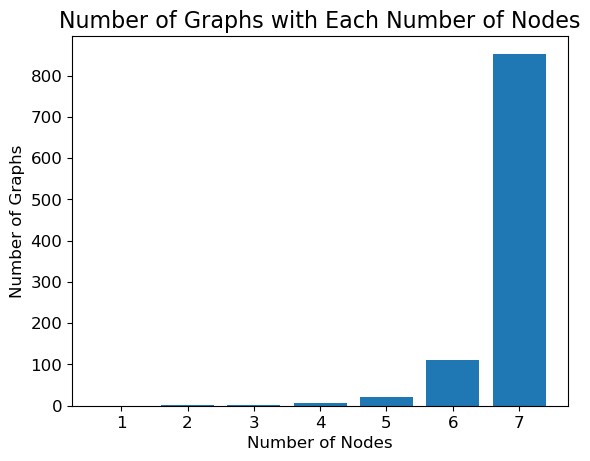

In [3]:
number_of_graphs_with_n_nodes = [len([G for G in Gs if G.number_of_nodes() == i]) for i in range(1, 8)]
plt.bar(range(1, 8), number_of_graphs_with_n_nodes)
plt.xlabel("Number of Nodes", fontsize=12)
plt.ylabel("Number of Graphs", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Number of Graphs with Each Number of Nodes", fontsize=16)
save_pdf(plt, 'graph_node_distribution')
plt.show()

## Preprocessing
We will start by assembeling all the graphs and graph products in a structured manner to make it easier to analyze different embedding methods. Furthermore we will create different categorical labels for the graphs. 

### Factor graphs
Using different factor graphs could change the embedding, and therefore the effect of the graph products. We will use the following factor graphs:
* Complete graph
* Path graph
* Star graph

Regarding the size of the factor graphs, we will use the following sizes:
* 3 nodes
* 5 nodes
* 7 nodes
* 13 nodes

In [4]:
factor_graphs = get_factor_dict(REDUCED_EXPERIMENT_FACTOR_SIZES)

### Graph products
Now we will create the graph products of the factor graphs with all the graphs considered.

In [5]:
graph_products = generate_graph_product_table(Gs, factors=factor_graphs)

### Categorical Labels
We will create categorical labels for the graphs. The labels will be based on:
* Number of nodes
* Number of edges
* Highest degree

In [6]:
num_nodes = np.array([G.number_of_nodes() for G in Gs])
num_edges = np.array([G.number_of_edges() for G in Gs])
highest_degree = np.array([max(dict(G.degree()).values()) for G in Gs])

node_normalized_highest_degree = highest_degree / num_nodes
edge_normalized_highest_degree = highest_degree / num_edges

## Basis Cycle counting
We will use the cycle counting method by preparing embedding each graph using a vector, where each entry contains the number of basis cycles of a certain length (the length is the index of the entry). We will then use different graph products and observe, how the cycle counts change.

### Embeddings
For all these graph products, as well as the initial graphs, we will create embeddings by counting cycles of different lengths. We will use an embedding size of 7*7=49, which is the maximum length of cycles in a graph product of two graphs with each 7 nodes.

In [7]:
cycle_embedded_graphs = counting(Gs, 49, "basis_cycle")
cycle_embedded_products = graph_products.map(lambda x: counting(x, 49, "basis_cycle"))

### Evaluation and Comparison
In this section, we will evaluate, how many graphs, that are isomorphic to each other, are mapped to the same embedding. We will also compare the embeddings of the different graph products.

In [8]:
cycle_results = compare(cycle_embedded_graphs, index=True)
cycle_product_results = cycle_embedded_products.map(lambda x: compare(x, index=True))

In [9]:
print("Number of non-isomorphic graphs with the same embedding: {}".format(cycle_results[0]))

Number of non-isomorphic graphs with the same embedding: 14239


In [10]:
results_to_latex(cycle_product_results.map(lambda x: x[0])) # construct latex table for report
cycle_product_results.map(lambda x: x[0])

Graph Product,Cartesian,Strong,Tensor,Modular,Lexicographic
Factor Graph,,,,,
K3,1096,11795,255,283,12742
K5,1040,9086,108,123,9977
K7,1039,9086,96,112,9977
K13,1039,9086,95,112,9977
P3,1407,787,7311,36,3299
P5,1404,33,549,7,3057
P7,1404,11,121,7,3057
P13,1404,5,49,5,3057
S3,191,1987,7263,72,4226


To further understand the different impact of different graph products, we will take the row-wise intersection, to see, how many graphs can not be distinguished, after using all the different graph products.

In [11]:
cycle_product_results.map(lambda x: x[1]).apply(lambda x: len(set.intersection(*x)), axis=1)

Factor Graph
K3     63
K5     26
K7     24
K13    24
P3      1
P5      0
P7      0
P13     0
S3      1
S5      1
S7      1
S13     1
dtype: int64

Next we will analyze if there are any pairs of graphs, that have the same embedding after a graph product, but not before. This would mean, that the graph product has worsened the embedding for this specific case.

In [12]:
cycle_product_results.map(lambda x: len(x[1] - cycle_results[1]))

Graph Product,Cartesian,Strong,Tensor,Modular,Lexicographic
Factor Graph,,,,,
K3,48,5210,29,45,4978
K5,10,2520,9,25,2226
K7,11,2520,6,24,2226
K13,11,2520,6,24,2226
P3,257,158,4648,14,1124
P5,255,3,201,2,903
P7,255,0,22,4,903
P13,255,0,5,2,903
S3,33,872,4612,49,2008


To further analyze the workings of basis cycles, we will look at the average number of basis cycles for the modular product with a path graph of size 5.

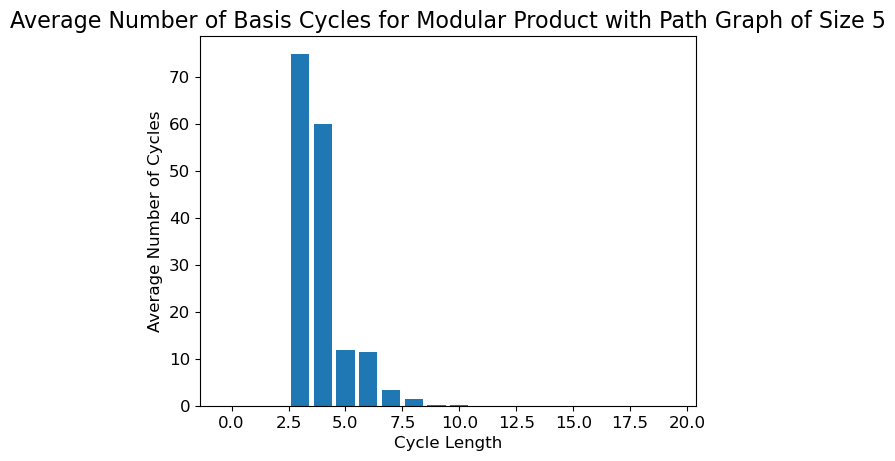

In [13]:
modular_path_5 = cycle_embedded_products.loc['P5', 'Modular']

avg_cycles_per_length = modular_path_5.mean(axis=0)

plt.bar(range(0, 20), avg_cycles_per_length[:20])
plt.xlabel("Cycle Length", fontsize=12)
plt.ylabel("Average Number of Cycles", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Average Number of Basis Cycles for Modular Product with Path Graph of Size 5", fontsize=16)
save_pdf(plt, 'cycle_avg')
plt.show()

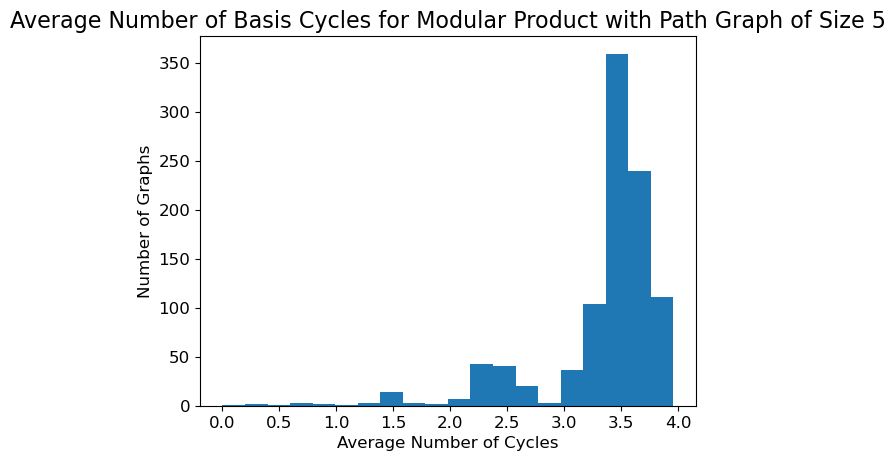

In [14]:
avg_cycles_per_graph = modular_path_5.mean(axis=1)

plt.hist(avg_cycles_per_graph, bins=20)
plt.xlabel("Average Number of Cycles", fontsize=12)
plt.ylabel("Number of Graphs", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Average Number of Basis Cycles for Modular Product with Path Graph of Size 5", fontsize=16)
save_pdf(plt, 'cycle_hist')
plt.show()

We also want to find the average density of the graphs that are part of a collision.

In [15]:
collisions = cycle_product_results.map(lambda x: x[1])
collision_participants = collisions.map(lambda cs: {G for collision in cs for G in collision})
collision_density = collision_participants.map(lambda cp: [Gs[G].number_of_edges() / (Gs[G].number_of_nodes() * (Gs[G].number_of_nodes() - 1) / 2) for G in cp])
avg_collision_density = collision_density.map(np.mean)
avg_collision_density

Graph Product,Cartesian,Strong,Tensor,Modular,Lexicographic
Factor Graph,,,,,
K3,0.501789,0.538955,0.492435,0.502500,0.538670
K5,0.455025,0.535104,0.483220,0.507750,0.533241
K7,0.452441,0.535104,0.480403,0.509323,0.533241
K13,0.452441,0.535104,0.480458,0.509323,0.533241
P3,0.523111,0.523380,0.533772,0.604996,0.532877
P5,0.527531,0.508703,0.528166,0.672109,0.532146
P7,0.527531,0.506494,0.506367,0.597279,0.532146
P13,0.527531,0.504762,0.478873,0.655238,0.532146
S3,0.553395,0.528416,0.533668,0.658156,0.532245


### Visualization
Seeing the effectiveness of the graph products, we will further investigate the embeddings of them by visualizing them. We will use the following visualization methods:
* Examples of graphs with the same embedding (before and after graph products)
* Examples of graphs with the same embedding (only after graph products)
* Examples of graphs with different embeddings (only after graph products)
* Examples of graphs with same embeddings after various graph products
* t-SNE

In [16]:
original_idx = cycle_results[1]
comparative_idx = cycle_product_results.loc['K7', 'Tensor'][1]

def sort_by_simiplicity(idx_pairs):
    """
    Sorts the index pairs by the combined number of nodes of both graphs.
    If the number of nodes is equal, the number of edges is used.
    This helps to find graphs, that are understandable by humans.
    """
    return sorted(idx_pairs, key=lambda x: (num_nodes[x[0]] + num_nodes[x[1]], num_edges[x[0]] + num_edges[x[1]]))

def plot_dual_examples(set_idx_pairs, num_examples=3, sort=True, fix_positions=False):
    if sort:
        idx_pairs = sort_by_simiplicity(set_idx_pairs)
    else:
        idx_pairs = list(set_idx_pairs)
    
    for i in range(num_examples):
        if i >= len(idx_pairs):
            print("Warning: Not enough examples to plot")
            break

        graph_pair = [Gs[idx_pairs[i][0]], Gs[idx_pairs[i][1]]]
        
        pos = nx.spring_layout(graph_pair[0]) if fix_positions else None
        plot(graph_pair, titles=['Graph 1', 'Graph 2'], figsize=(10, 5), pos=pos)

#### Examples of graphs with the same embedding (before and after graph products)

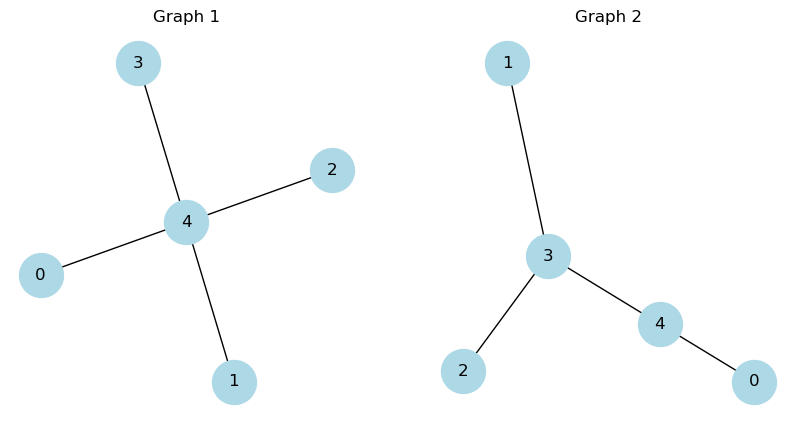

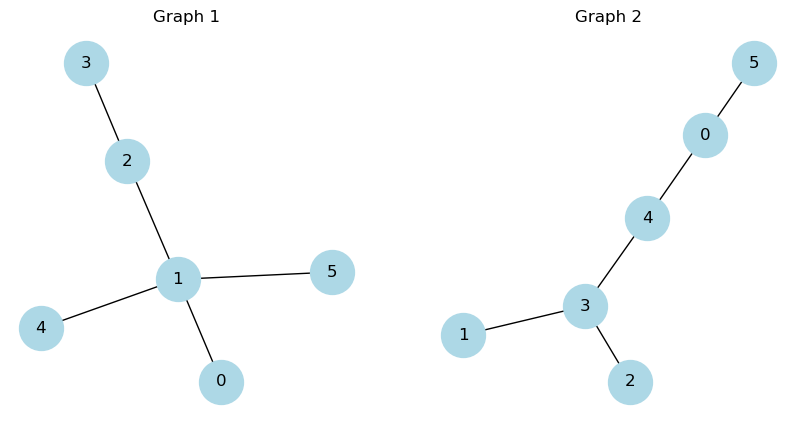

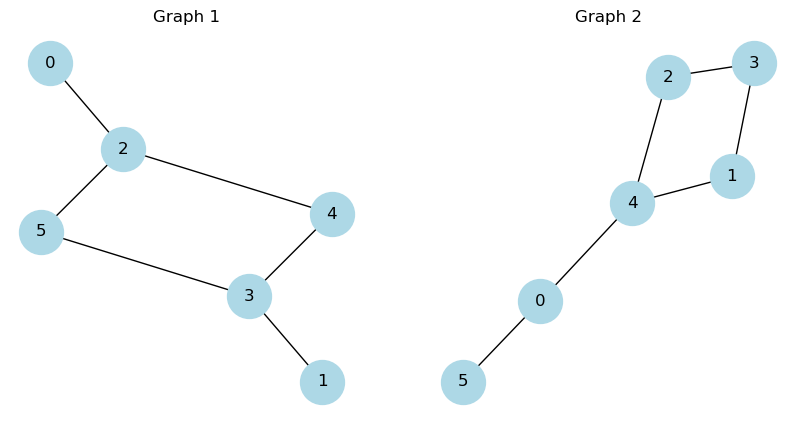

In [17]:
common_idx = original_idx.intersection(comparative_idx)

plot_dual_examples(common_idx)

#### Examples of graphs with the same embedding (only after graph products)

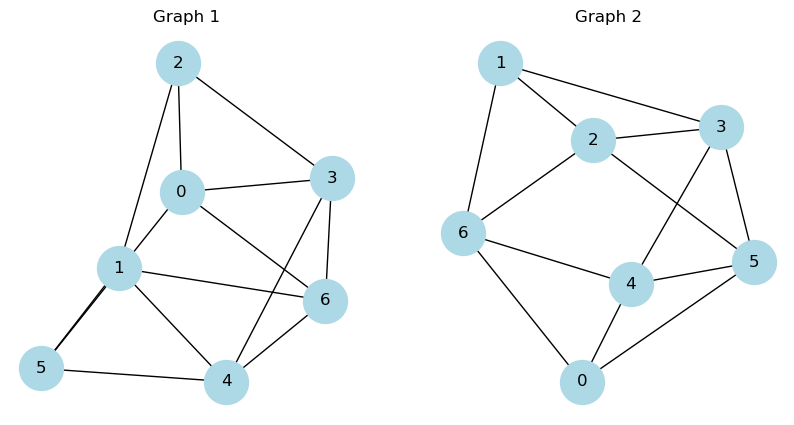

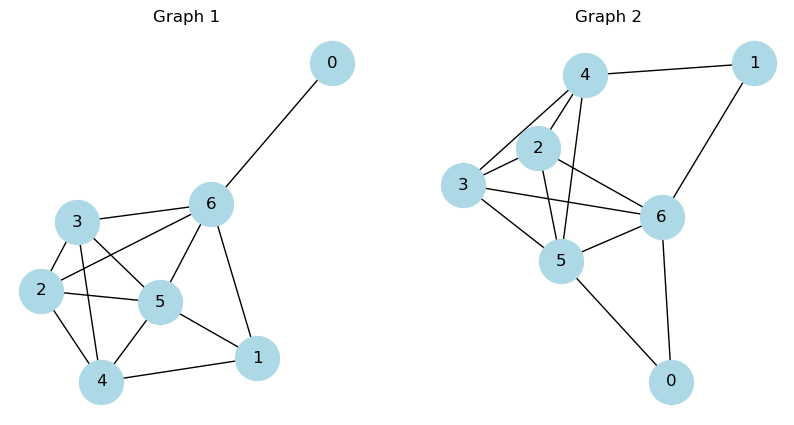

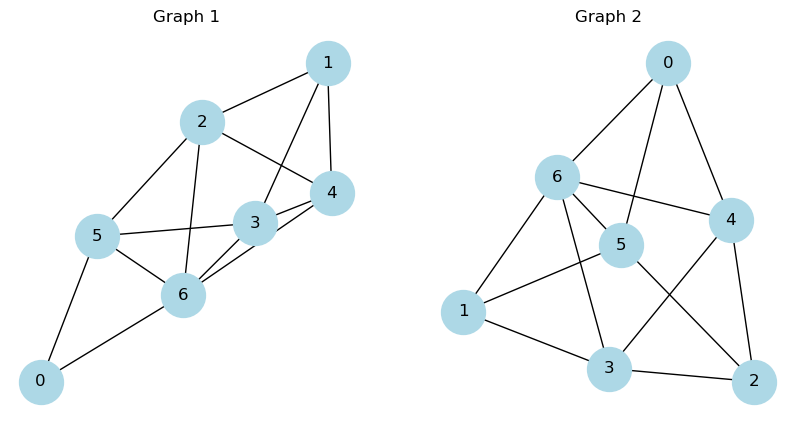

In [18]:
same_only_after_idx = comparative_idx - original_idx

plot_dual_examples(same_only_after_idx)

#### Examples of graphs with different embeddings (only after graph products)

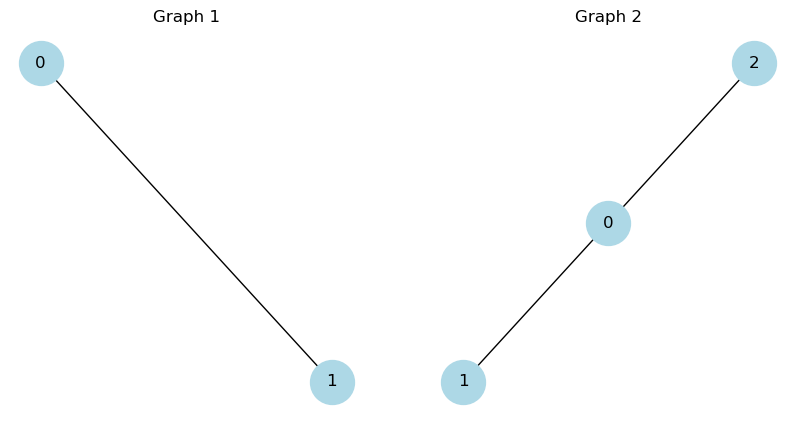

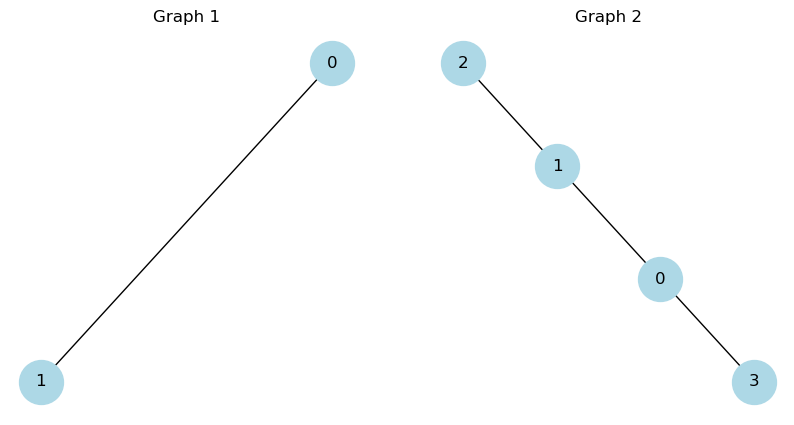

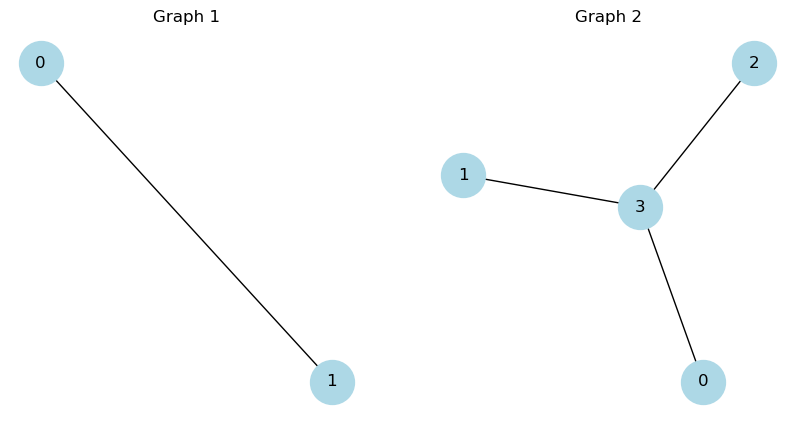

In [19]:
different_only_after_idx = original_idx - comparative_idx

plot_dual_examples(different_only_after_idx)

#### Examples of graphs with same embeddings after various graph products

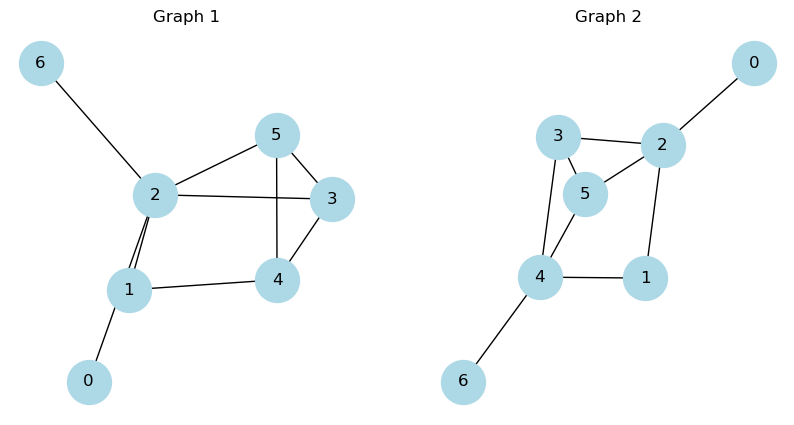

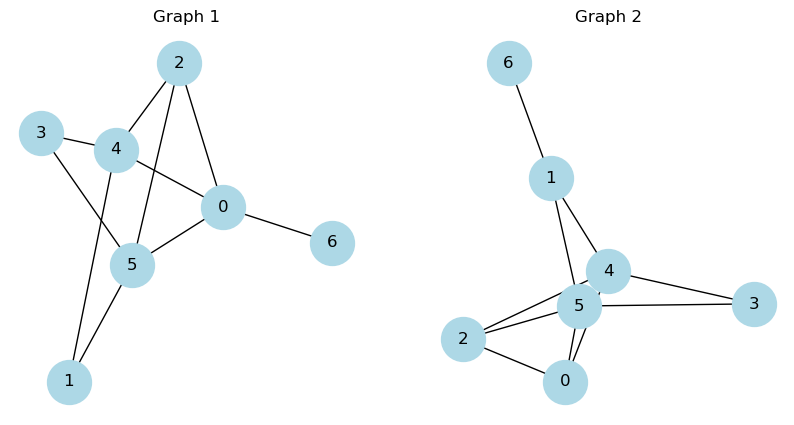

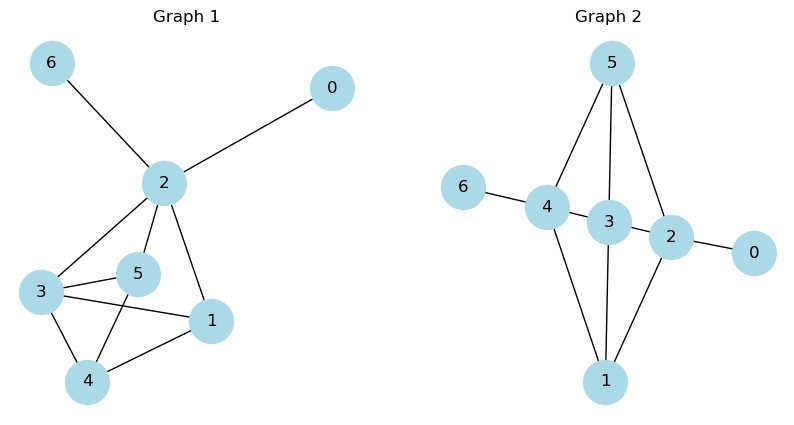

In [20]:
# Change the factor graphs to compare and the graph products to compare
factor_graphs_to_compare = ['K7', 'P7']
graph_products_to_compare = ['Strong', 'Tensor']

similar_for_all_idx = original_idx.intersection(*cycle_product_results.loc[factor_graphs_to_compare, graph_products_to_compare].map(lambda x: x[1]).values.flatten())

plot_dual_examples(similar_for_all_idx)

#### t-SNE
The **T-distibuted Stochastic Neighbor Embedding** (t-SNE) is a dimensionality reduction technique, that is often used for visualizing high-dimensional data. It is a non-linear technique, that is particularly well suited for embedding data into a space of two or three dimensions, which can then be visualized in a scatter plot. Specifically, it models each high-dimensional object in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

We will use t-SNE to visualize the embeddings of the graphs. We employ different color schemes to represent categorical attributes of the graphs, such as the number of nodes, the number of edges, and the highest degree.

In [21]:
# Choose one of the options to be the color mapping for the t-SNE plots
cmap_num_nodes = ("Number of Nodes", num_nodes)
cmap_num_edges = ("Number of Edges", num_edges)
cmap_highest_degree = ("Highest Degree", highest_degree)
cmap_node_normalized_highest_degree = ("Node Normalized Highest Degree", node_normalized_highest_degree)
cmap_edge_normalized_highest_degree = ("Edge Normalized Highest Degree", edge_normalized_highest_degree) 

# Change this variable to change the color mapping
color_mapping = cmap_num_edges

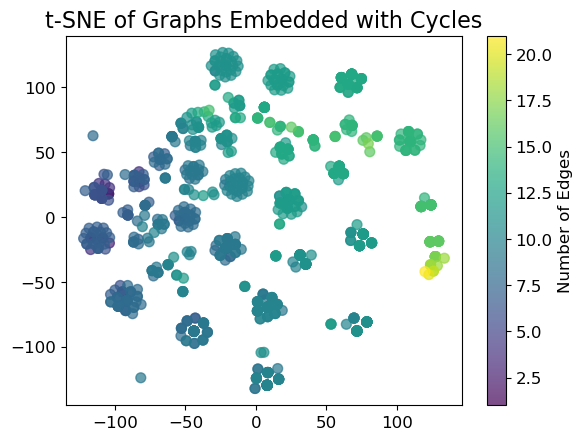

In [22]:
tsne = TSNE(n_components=2)
tsne_graphs = tsne.fit_transform(cycle_embedded_graphs)

sc = plt.scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=color_mapping[1],
                 cmap='viridis',
                 s=50)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("t-SNE of Graphs Embedded with Cycles", fontsize=16)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(color_mapping[0], fontsize=12)
save_pdf(plt, 'tsne_original')
plt.show()

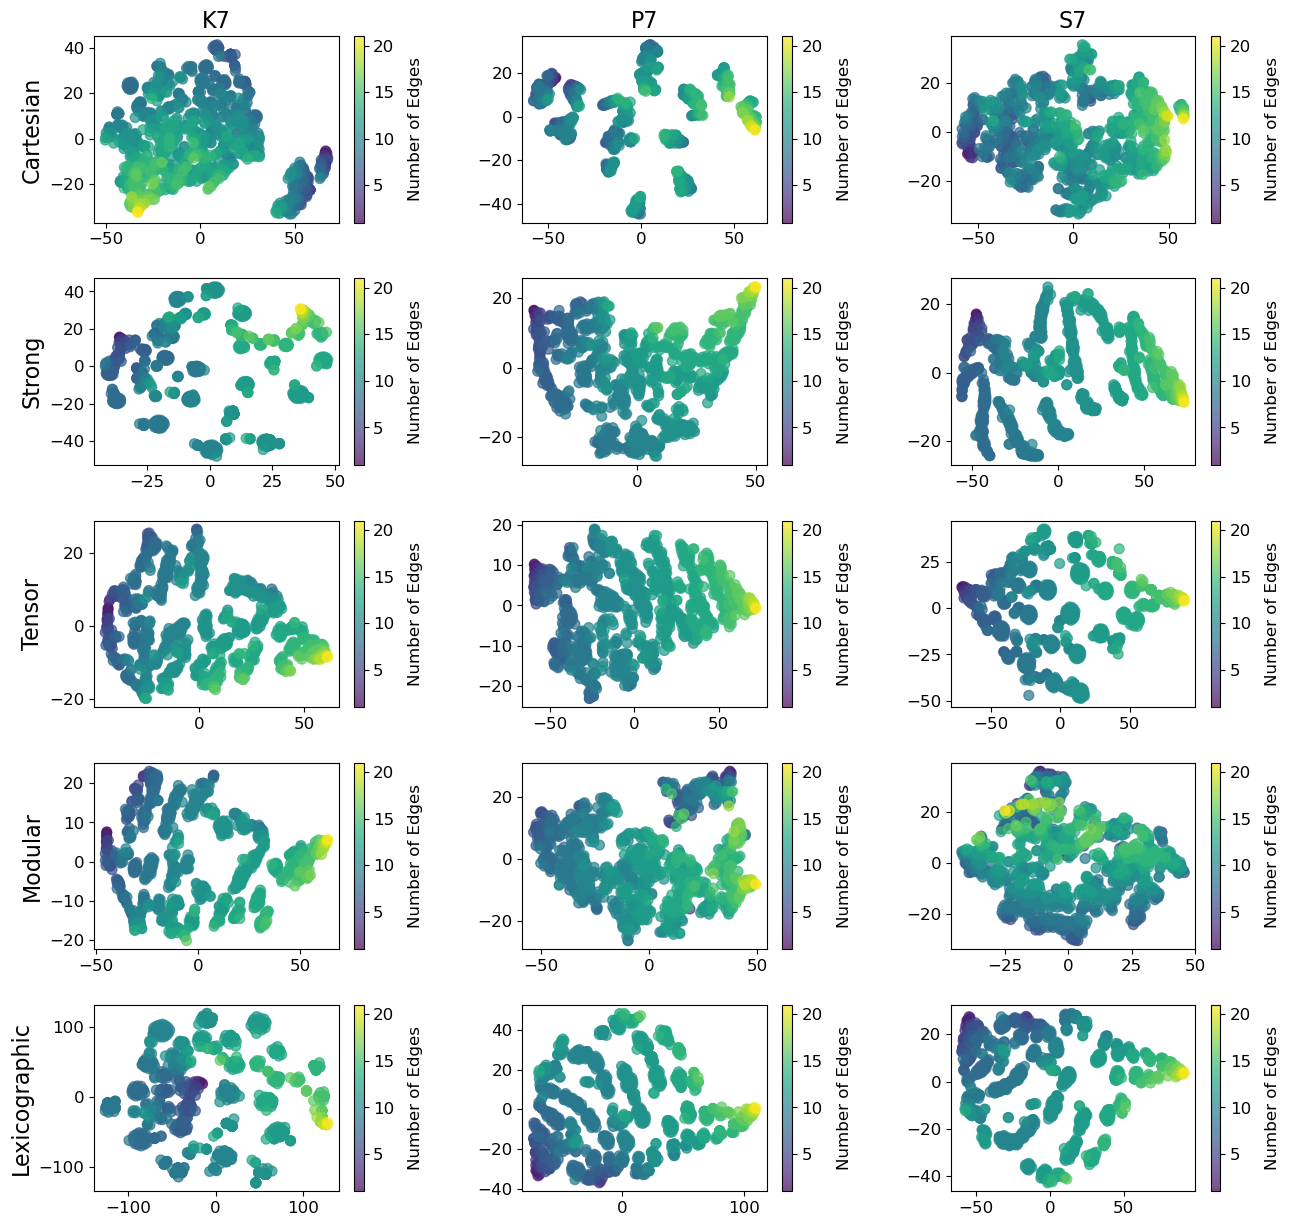

In [23]:
chosen_factor_graphs = ['K7', 'P7', 'S7']

fig, axes = plt.subplots(len(cycle_embedded_products.columns),
                         len(chosen_factor_graphs), 
                         figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for j, factor_graph in enumerate(['K7', 'P7', 'S7']):
    comparative_cycle_embedded_graphs = cycle_embedded_products.loc[factor_graph]
    for i, (product_name, embeddings) in enumerate(comparative_cycle_embedded_graphs.items()):
        tsne = TSNE(n_components=2)
        tsne_graphs = tsne.fit_transform(embeddings)
        sc = axes[i, j].scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=color_mapping[1],
                 cmap='viridis',
                 s=50)
        axes[i, j].tick_params(axis='both', which='major', labelsize=12)

        cbar = plt.colorbar(sc, ax=axes[i, j])
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label(color_mapping[0], fontsize=12, labelpad=10)
    axes[0, j].set_title(factor_graph, fontsize=16)

for i, product_name in enumerate(cycle_embedded_products.columns):
    axes[i, 0].set_ylabel(product_name, fontsize=16)

save_pdf(plt, 'tsne_product')
plt.show()

## Union Embeddings
This section will explore the effect of combining embeddings from different product-factor combinations, and how this affects the ability to distinguish between graphs. For this we will simply concatenate the embeddings of the different product-factor combinations.

In [24]:
union_products = [(x, y) for x in available_products for y in available_products if x != y]

cycle_embedded_union = pd.DataFrame(index=factor_graphs.keys(), columns=union_products)
cycle_embedded_union.index.name = 'Factor Graph'
cycle_embedded_union.columns = pd.MultiIndex.from_tuples(cycle_embedded_union.columns, names=['Product 1', 'Product 2'])

for factor_name in factor_graphs:
    for product1, product2 in union_products:
        cycle_embedded_union.loc[factor_name, (product1, product2)] = np.concatenate([cycle_embedded_products.loc[factor_name, product1], cycle_embedded_products.loc[factor_name, product2]], axis=1)


cycle_union_results = cycle_embedded_union.map(lambda x: compare(x, index=True))

cycle_union_results.map(lambda x: x[0])

Product 1    Cartesian                                 Strong                 \
Product 2       Strong Tensor Modular Lexicographic Cartesian Tensor Modular   
Factor Graph                                                                   
K3                1029    161     118          1079      1029    236     220   
K5                1030     75      50          1038      1030    101      94   
K7                1028     71      45          1039      1028     92      84   
K13               1028     71      45          1039      1028     91      84   
P3                 167    592      18           623       167    330       2   
P5                   7     88       6           635         7      3       0   
P7                   7     28       5           635         7      4       0   
P13                  5      7       4           635         5      1       0   
S3                 113     73       4           134       113    634       6   
S5                 112     71       4           131       112    797       7   
S7                 111     71       4           131       111    525       7   
S13                111     71       4           131       111    542       6   

Product 1                     Tensor                                Modular  \
Product 2    Lexicographic Cartesian Strong Modular Lexicographic Cartesian   
Factor Graph                                                                  
K3                    9873       161    236      95           243       118   
K5                    7263        75    101      32           102        50   
K7                    7263        71     92      27            92        45   
K13                   7263        71     91      27            91        45   
P3                     223       592    330      19           969        18   
P5                      12        88      3       1           143         6   
P7                       5        28      4       0            45         5   
P13                      5         7      1       0            18         4   
S3                     648        73    634      11          1132         4   
S5                     603        71    797       9           950         4   
S7                     513        71    525       9           915         4   
S13                    513        71    542       7           915         4   

Product 1                                Lexicographic                        
Product 2    Strong Tensor Lexicographic     Cartesian Strong Tensor Modular  
Factor Graph                                                                  
K3              220     95           270          1079   9873    243     270  
K5               94     32           120          1038   7263    102     120  
K7               84     27           109          1039   7263     92     109  
K13              84     27           109          1039   7263     91     109  
P3                2     19            20           623    223    969      20  
P5                0      1             6           635     12    143       6  
P7                0      0             5           635      5     45       5  
P13               0      0             4           635      5     18       4  
S3                6     11            22           134    648   1132      22  
S5                7      9            21           131    603    950      21  
S7                7      9            21           131    513    915      21  
S13               6      7            21           131    513    915      21

### Results and Discussion
We will discuss the results of the previous sections and draw conclusions.

Applying the graph products to graphs before embedding them using a cycle counting approach has show to be effective. The number of graphs that are mapped to the same embedding is reduced drastically. Interestingly, we can note the effectiveness of different graph products with specific factor graphs. For example, the tensor product with a complete graph or a path grap as a factor graph is very effective, while the tensor product with a star graph as a factor graph is not very effective. Conversely, the Cartesian product with a star graph as a factor graph is very effective, while the Cartesian product with a complete graph or a path graph as a factor graph is not very effective. The strong product is especially effective with the path graph. 

The combination of the modular- and strong graph products with the path graph as a factor graph are the most effective combinations. They are able to map all but 5 graph pairs to different embeddings. This is a very good result, even improving upon the results of the Weisfeiler-Lehman algorithm, which has a total of 20 graph pairs that are mapped to the same embedding.

The t-SNE visualization corroborates the results, as described above. We can see that for certain combinations of graph products and factor graphs, the embedding space is evenly separated, whereas for other combinations, there are narrow clusters of embeddings, which indicates that many graphs are mapped to the same embedding.

## Weisfeiler-Lehman
Next will use the standard one dimensional Weisfeiler-Lehman isomorphism test and perform the same evaluations and comparisons as before.

### Embeddings
We will use 10 iterations of the Weisfeiler-Lehman algorithm to create the embeddings.

In [25]:
wl_embedded_graphs = wl(Gs, 10)
wl_embedded_products = graph_products.map(lambda x: wl(x, 10))

### Evaluation and Comparison
In this section, we will evaluate the effectiveness of graph products ability to enhance the WL isomorphism test. 

In [26]:
wl_results = compare(wl_embedded_graphs)
wl_product_results = wl_embedded_products.map(lambda x: compare(x, index=True))

In [27]:
wl_results

20

In [28]:
wl_product_results.map(lambda x: x[0])

Graph Product,Cartesian,Strong,Tensor,Modular,Lexicographic
Factor Graph,,,,,
K3,20,20,20,20,20
K5,20,20,20,20,20
K7,20,20,20,20,20
K13,20,20,20,20,20
P3,20,20,20,20,20
P5,20,20,20,20,20
P7,20,20,20,20,20
P13,20,20,20,20,20
S3,20,20,20,20,20


As we can see from the table above, the graph products showed no effect on enhancing the WL isomorphism test.

## Cycle counting vs. Weisfeiler-Lehman
In this section we will compare the cycle counting approach with the Weisfeiler-Lehman algorithm. More specifically, we will visualize non-isomorphic graphs that are not correctly identified by the Weisfeiler-Lehman algorithm, but are distinctly embedded by the cycle counting approach.

First, we will analyze how many collisions are present in **both** the embeddings of the Weisfeiler-Lehman algorithm **and** the cycle counting approach

In [29]:
collision_intersections = pd.DataFrame(index=factor_graphs.keys(), columns=available_products)

for factor_graph in factor_graphs:
    for product_name in available_products:
        collision_intersections.loc[factor_graph, product_name] = len(wl_product_results.loc[factor_graph, product_name][1].intersection(cycle_product_results.loc[factor_graph, product_name][1]))

collision_intersections

,Cartesian,Strong,Tensor,Modular,Lexicographic
K3,0,0,0,0,2
K5,0,0,0,0,2
K7,0,0,0,0,2
K13,0,0,0,0,2
P3,0,0,2,0,1
P5,0,0,0,0,1
P7,0,0,0,0,1
P13,0,0,0,0,1
S3,0,0,2,0,1
S5,0,0,2,0,1


As the set difference of the two sets of collisions shows, Nearly all collisions of the Weisfeiler-Lehman algorithm distinct from the collisions of the cycle counting approach. We will now visualize collisions of the Weisfeiler-Lehman algorithm and subsequently collisions of the cycle counting approach.

In [30]:
collision_wl_idx = wl_product_results.loc['P13', 'Modular'][1]
collision_cycle_idx = cycle_product_results.loc['P13', 'Modular'][1]

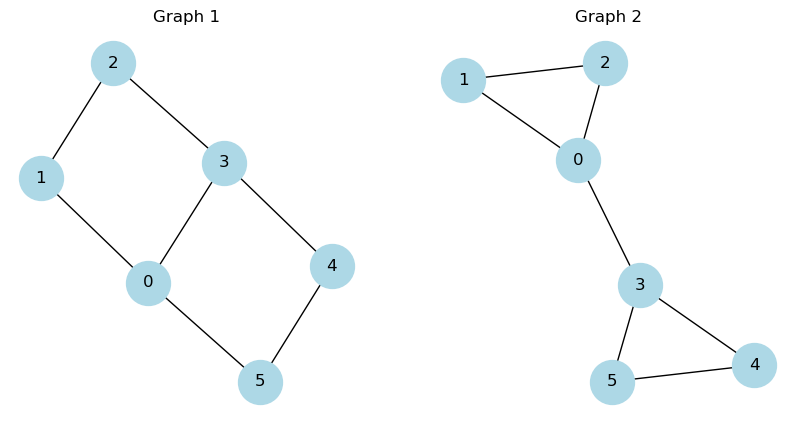

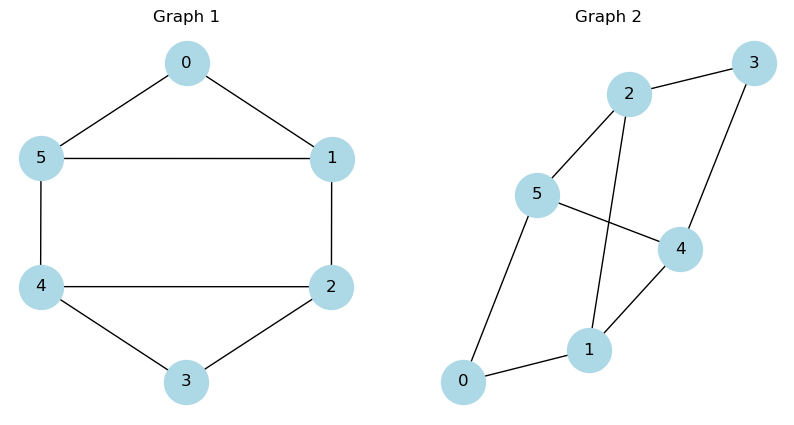

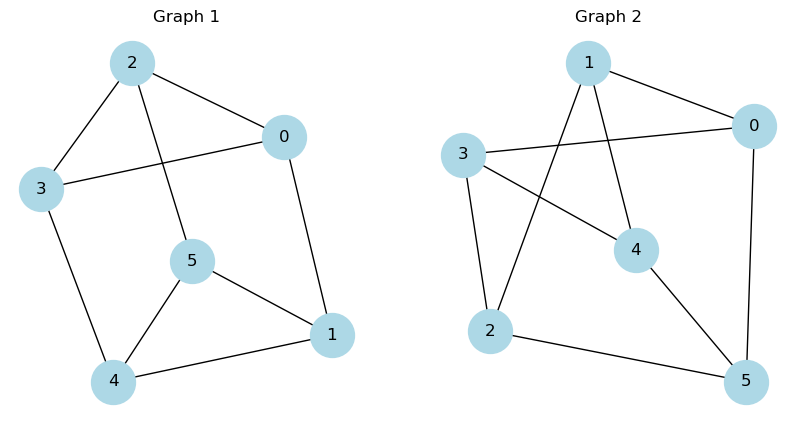

In [31]:
plot_dual_examples(collision_wl_idx, num_examples=3)

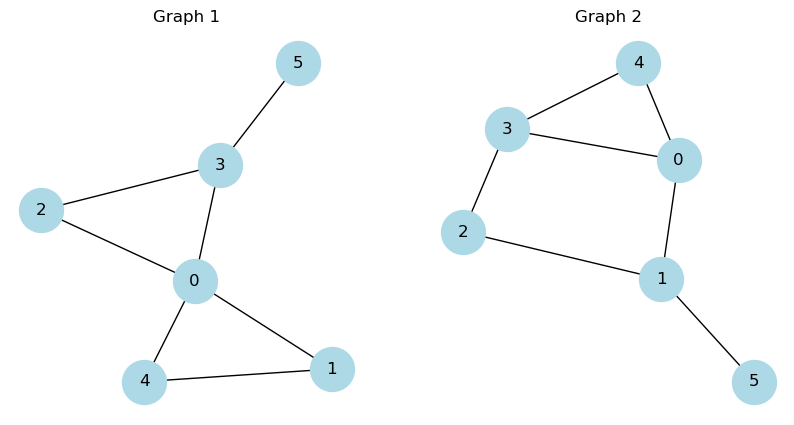

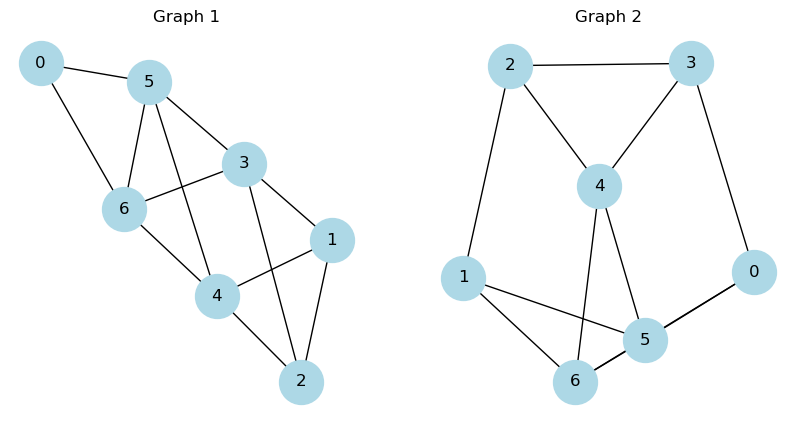

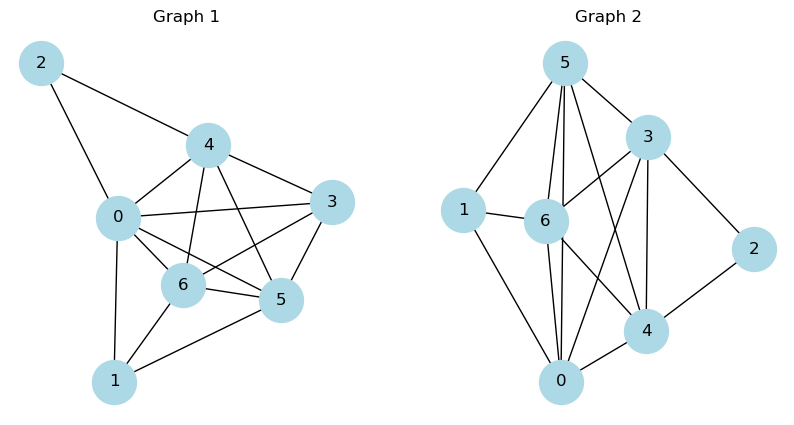

In [32]:
plot_dual_examples(collision_cycle_idx, num_examples=3)

## Degree counting
We will use the degree counting method by embedding each graph using a vector, where each entry contains the number of nodes of a certain degree. We will then use different graph products and observe, how the degree counts change.

### Embeddings
For all these graph products, as well as the initial graphs, we will create embeddings by counting degrees of different lengths. We will use an embedding size of 128, which is the far greater than the maximum degree of a nodes in a graph product of two graphs with 7 nodes and 13-14 nodes.

In [33]:
degree_embedded_graphs = counting(Gs, 128, "degree")
degree_embedded_products = graph_products.map(lambda x: counting(x, 128, "degree"))

### Evaluation and Comparison
In this section, we will evaluate, how many graphs, that are isomorphic to each other, are mapped to the same embedding. We will also compare the embeddings of the different graph products.

In [34]:
degree_results = compare(degree_embedded_graphs, index=True)
degree_product_results = degree_embedded_products.map(lambda x: compare(x, index=True))

In [35]:
print("Number of non-isomorphic graphs with the same embedding: {}".format(degree_results[0]))

Number of non-isomorphic graphs with the same embedding: 3125


In [36]:
degree_product_results.map(lambda x: x[0])

Graph Product,Cartesian,Strong,Tensor,Modular,Lexicographic
Factor Graph,,,,,
K3,3125,3125,3125,3125,3125
K5,3125,3125,3125,3125,3125
K7,3125,3125,3125,3125,3125
K13,3125,3125,3125,3125,3125
P3,3125,3125,3125,3125,3125
P5,3125,3125,3125,3125,3125
P7,3125,3125,3125,3125,3125
P13,3125,3125,3125,3125,3125
S3,3125,3125,3125,3125,3125


It appears for the degree to show invariance to graph products of all tested kinds. This should be further investigated. Let's first compare embeddings of the same graph before and after graph products. 

In [37]:
def plot_embedding_diff(before, after):
    highest_idx = np.max(np.nonzero(after))

    before = before[:highest_idx + 1]
    after = after[:highest_idx + 1]
    print(f"Before: {before}")
    print(f"After: {after}")
    pd.DataFrame({'Before': before, 'After': after}).plot.bar(figsize=(15, 5))

Before: [0 2 3 0 2 0 0 0 0 0 0]
After: [ 0  0  0  0  0  0  0 14 21  0 14]


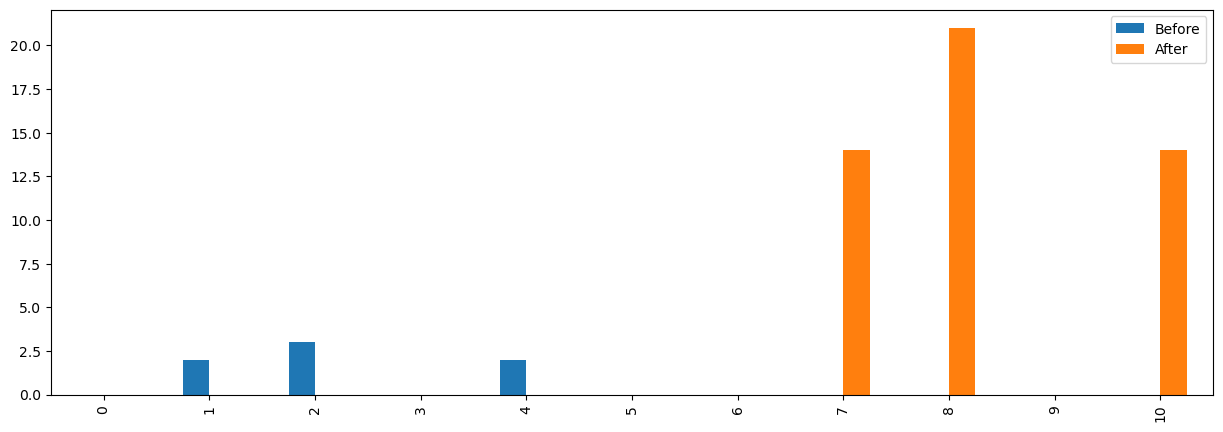

In [38]:
before = degree_embedded_graphs[200]
after = degree_embedded_products.loc['K7', 'Cartesian'][200]
plot_embedding_diff(before, after)

Before: [0 2 3 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
After: [ 0  0  0  0  0  0  0  0  0  0  0  0  0 26 39  0 26]


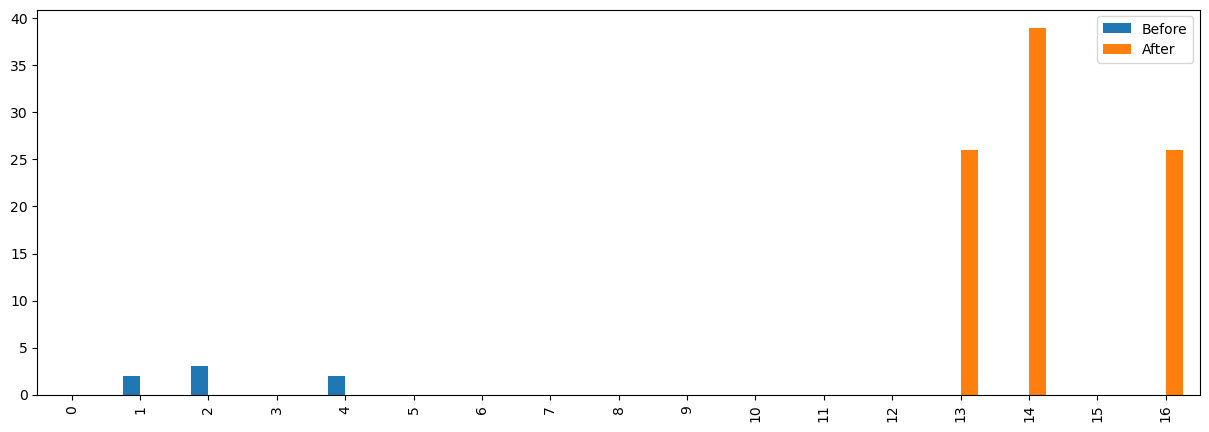

In [39]:
after = degree_embedded_products.loc['K13', 'Cartesian'][200]
plot_embedding_diff(before, after)

Before: [0 2 3 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
After: [ 0  0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0
 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 26]


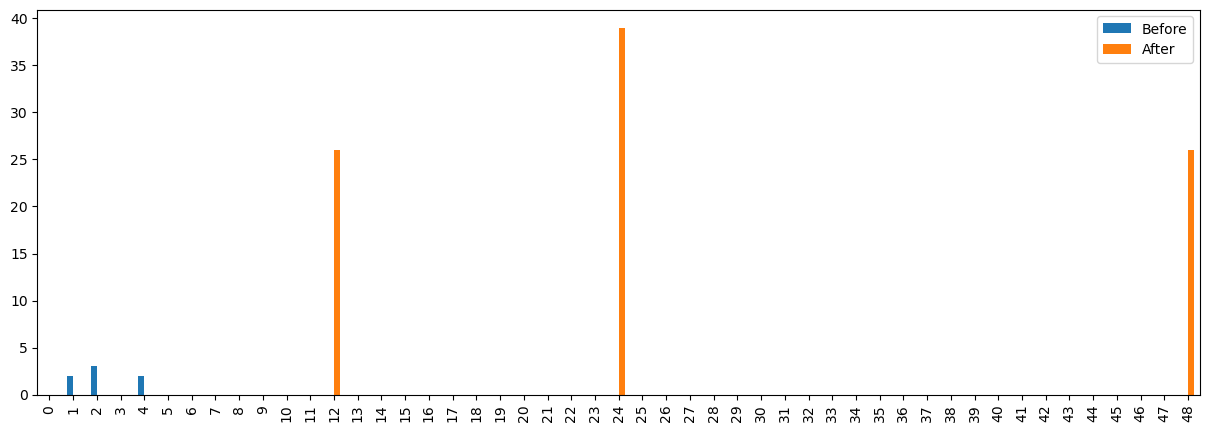

In [40]:
after = degree_embedded_products.loc['K13', 'Tensor'][200]
plot_embedding_diff(before, after)

Apparantly, graph products only scale the degree counts, but do make any other changes. This is why the embeddings of the product graphs, while different, have the same collisions as the embeddings of the original graphs. This is why the graph products do not improve the embeddings.

Looking at the experimental results in more detail, we can see:
- The number of nodes with a specific degree is multiplied by the size (number of nodes) of the factor graph
- The degree itself is depending on the product used either just shifted or scaled as well.

## Degree sequence
We will use the degree sequence method by embedding each graph using a vector, representing the decreasing node degrees. We will then use different graph products and observe, how the degree sequences change.

In [41]:
ds_embedded_graphs = counting(Gs, 128, "degree_sequence")
ds_embedded_products = graph_products.map(lambda x: counting(x, 128, "degree_sequence"))

### Evaluation and Comparison
In this section, we will evaluate, how many graphs, that are isomorphic to each other, are mapped to the same embedding. We will also compare the embeddings of the different graph products.

In [42]:
ds_results = compare(ds_embedded_graphs, index=True)
ds_product_results = ds_embedded_products.map(lambda x: compare(x, index=True))

In [43]:
print("Number of non-isomorphic graphs with the same embedding: {}".format(ds_results[0]))

Number of non-isomorphic graphs with the same embedding: 3125


In [44]:
ds_product_results.map(lambda x: x[0])

Graph Product,Cartesian,Strong,Tensor,Modular,Lexicographic
Factor Graph,,,,,
K3,3125,3125,3125,3125,3125
K5,3125,3125,3125,3125,3125
K7,3125,3125,3125,3125,3125
K13,3125,3125,3125,3125,3125
P3,3125,3125,3125,3125,3125
P5,3125,3125,3125,3125,3125
P7,3125,3125,3125,3125,3125
P13,3125,3125,3125,3125,3125
S3,3125,3125,3125,3125,3125


## Chordless Cycle counting
Now we will count chordless cycles of different lengths. We will then use different graph products and observe, how the cycle counts change. The process is similar to the basys cycle counting method, but we will use a reduced set of graph products and factor graphs, as the computational complexity of counting chordless cycles is higher than counting basis cycles.

In [45]:
red_factor_graphs = get_factor_dict([3, 5, 7])
red_graph_products = generate_graph_product_table(Gs, products=["Cartesian", "Strong", "Tensor", "Modular"], factors=red_factor_graphs)

### Embeddings
For all these graph products, as well as the initial graphs, we will create embeddings by counting cycles of different lengths. We will use an embedding size of 7*7=49, which is the maximum length of cycles in a graph product of two graphs with each 7 nodes.

In [46]:
chord_cycle_embedded_graphs = counting(Gs, 49, "chordless_cycle")
chord_cycle_embedded_products = red_graph_products.map(lambda x: counting(x, 49, "chordless_cycle"))

### Evaluation and Comparison
In this section, we will evaluate, how many graphs, that are isomorphic to each other, are mapped to the same embedding. We will also compare the embeddings of the different graph products.

In [47]:
chord_cycle_results = compare(chord_cycle_embedded_graphs, index=True)
chord_cycle_product_results = chord_cycle_embedded_products.map(lambda x: compare(x, index=True))

In [48]:
print("Number of non-isomorphic graphs with the same embedding: {}".format(chord_cycle_results[0]))

Number of non-isomorphic graphs with the same embedding: 6989


In [49]:
chord_cycle_product_results.map(lambda x: x[0])

Graph Product,Cartesian,Strong,Tensor,Modular
Factor Graph,,,,
K3,1245,3952,0,0
K5,1244,3952,0,0
K7,1244,3952,0,0
P3,1,11,332,0
P5,0,0,12,0
P7,0,0,5,0
S3,0,5,350,0
S5,0,5,362,0
S7,0,5,327,0


To further analyze the workings of chordless cycle, we will look at the average number of chordless cycles for the modular product with a path graph of size 5.

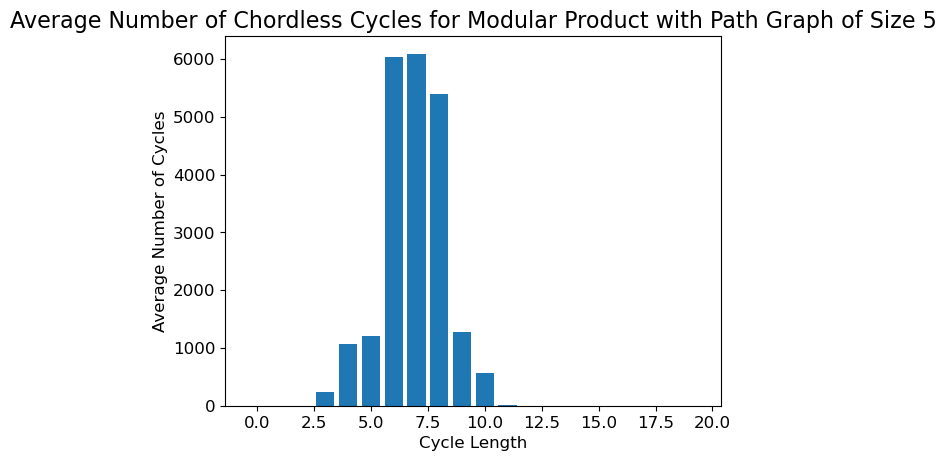

In [50]:
chord_modular_path_5 = chord_cycle_embedded_products.loc['P5', 'Modular']

chord_avg_cycles_per_length = chord_modular_path_5.mean(axis=0)

plt.bar(range(0, 20), chord_avg_cycles_per_length[:20])
plt.xlabel("Cycle Length", fontsize=12)
plt.ylabel("Average Number of Cycles", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Average Number of Chordless Cycles for Modular Product with Path Graph of Size 5", fontsize=16)
save_pdf(plt, 'chordless_cycle_avg')
plt.show()

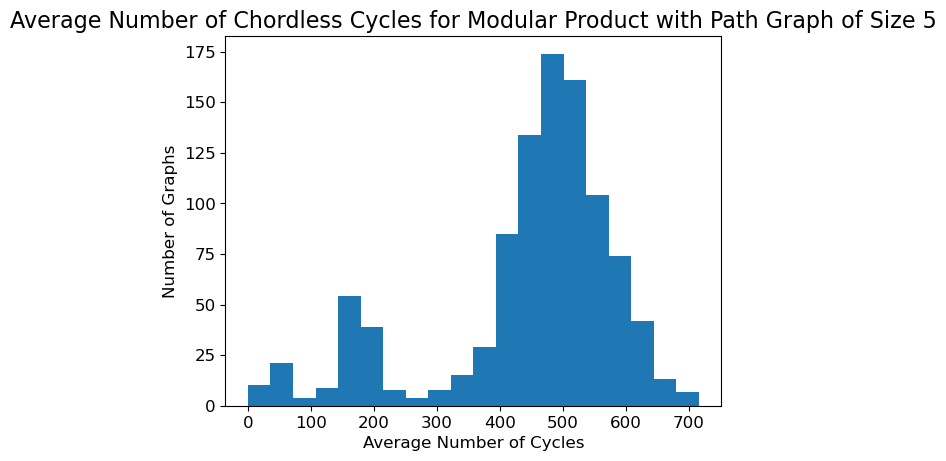

In [51]:
chord_avg_cycles_per_graph = chord_modular_path_5.mean(axis=1)

plt.hist(chord_avg_cycles_per_graph, bins=20)
plt.xlabel("Average Number of Cycles", fontsize=12)
plt.ylabel("Number of Graphs", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Average Number of Chordless Cycles for Modular Product with Path Graph of Size 5", fontsize=16)
save_pdf(plt, 'chordless_cycle_hist')
plt.show()

Seeing the effectiveness of the graph products, we will further investigate the embeddings of them by visualizing them. We will use the following visualization methods:
* Examples of graphs with the same embedding (before and after graph products)
* Examples of graphs with the same embedding (only after graph products)
* Examples of graphs with different embeddings (only after graph products)
* Examples of graphs with same embeddings after various graph products

In [52]:
chord_original_idx = chord_cycle_results[1]
chord_comparative_idx = chord_cycle_product_results.loc['K7', 'Tensor'][1]

#### Examples of graphs with the same embedding (before and after graph products)

In [53]:
chord_common_idx = chord_original_idx.intersection(chord_comparative_idx)

plot_dual_examples(chord_common_idx)

#### Examples of graphs with the same embedding (only after graph products)

In [54]:
chord_same_only_after_idx = chord_comparative_idx - chord_original_idx

plot_dual_examples(chord_same_only_after_idx)

#### Examples of graphs with different embeddings (only after graph products)

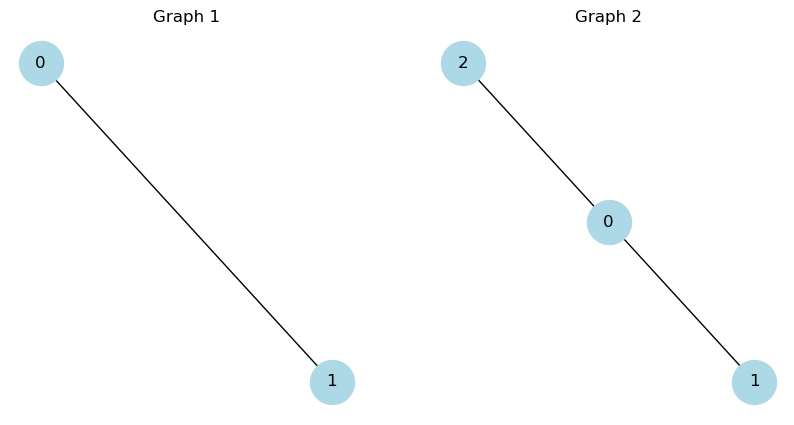

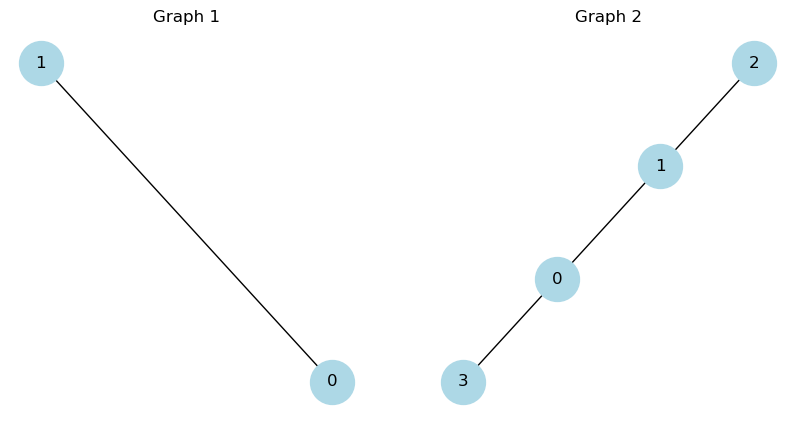

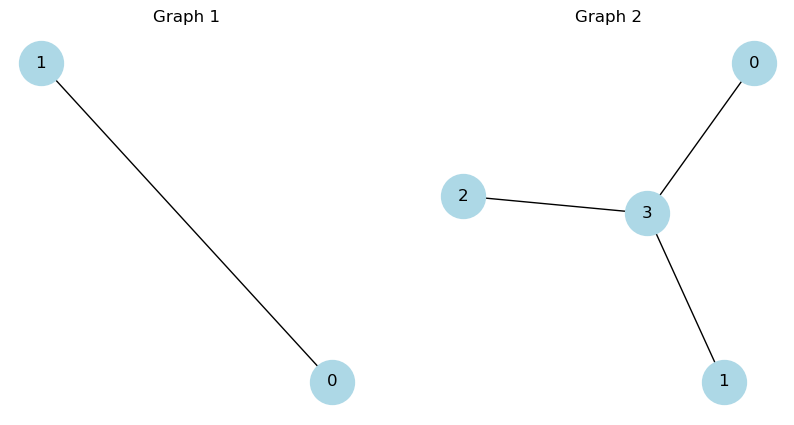

In [55]:
chord_different_only_after_idx = chord_original_idx - chord_comparative_idx

plot_dual_examples(chord_different_only_after_idx)

#### Examples of graphs with same embeddings after various graph products

In [56]:
# Change the factor graphs to compare and the graph products to compare
chord_factor_graphs_to_compare = ['K7', 'P7']
chord_graph_products_to_compare = ['Strong', 'Tensor']

chord_similar_for_all_idx = chord_original_idx.intersection(*chord_cycle_product_results.loc[chord_factor_graphs_to_compare, chord_graph_products_to_compare].map(lambda x: x[1]).values.flatten())

plot_dual_examples(chord_similar_for_all_idx)

### t-SNE
We will again observe the t-SNE visualization of the embeddings.

In [57]:
# Choose one of the options to be the color mapping for the t-SNE plots
cmap_num_nodes = ("Number of Nodes", num_nodes)
cmap_num_edges = ("Number of Edges", num_edges)
cmap_highest_degree = ("Highest Degree", highest_degree)
cmap_node_normalized_highest_degree = ("Node Normalized Highest Degree", node_normalized_highest_degree)
cmap_edge_normalized_highest_degree = ("Edge Normalized Highest Degree", edge_normalized_highest_degree) 

# Change this variable to change the color mapping
color_mapping = cmap_num_edges

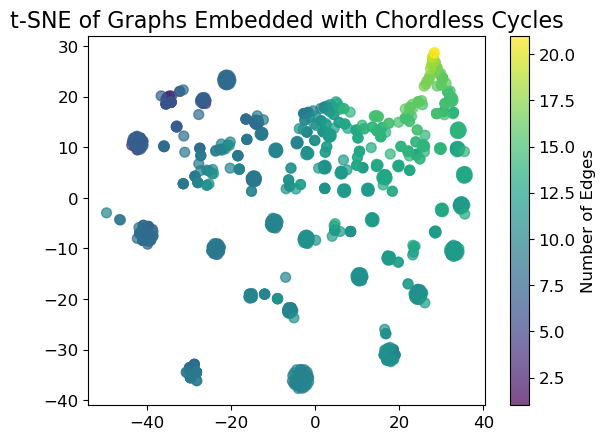

In [58]:
tsne = TSNE(n_components=2)
tsne_graphs = tsne.fit_transform(chord_cycle_embedded_graphs)

sc = plt.scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=color_mapping[1],
                 cmap='viridis',
                 s=50)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("t-SNE of Graphs Embedded with Chordless Cycles", fontsize=16)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(color_mapping[0], fontsize=12)
save_pdf(plt, 'tsne_original_chordless')
plt.show()

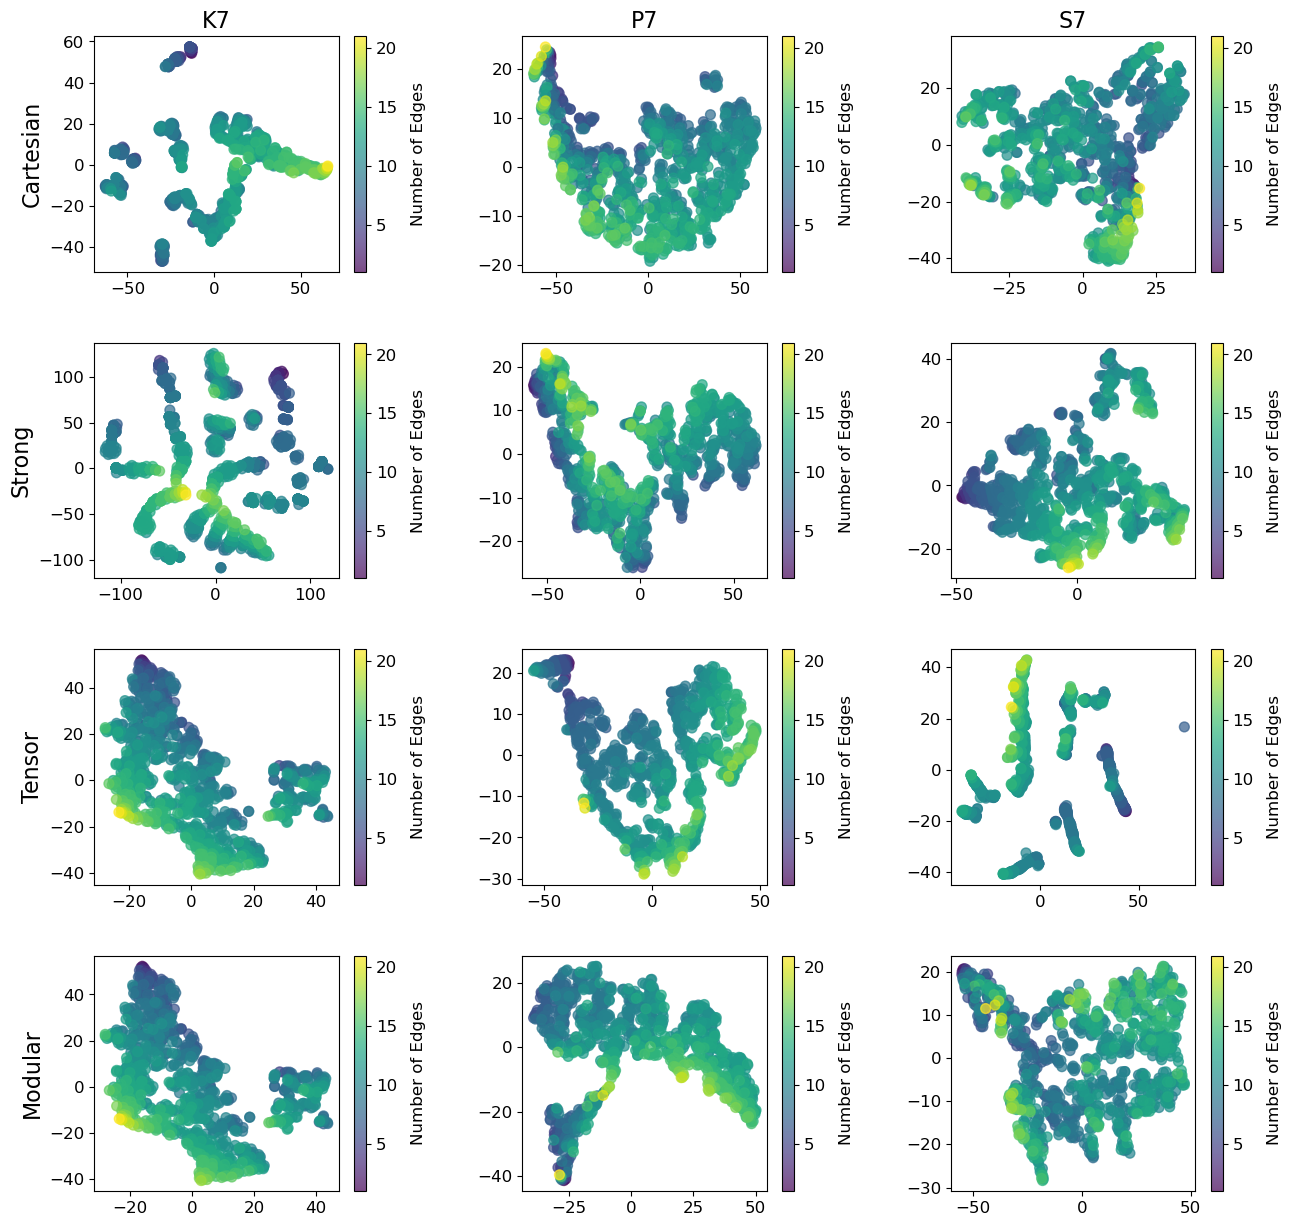

In [59]:
chosen_factor_graphs = ['K7', 'P7', 'S7']

fig, axes = plt.subplots(len(chord_cycle_embedded_products.columns),
                         len(chosen_factor_graphs), 
                         figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for j, factor_graph in enumerate(['K7', 'P7', 'S7']):
    comparative_cycle_embedded_graphs = chord_cycle_embedded_products.loc[factor_graph]
    for i, (product_name, embeddings) in enumerate(comparative_cycle_embedded_graphs.items()):
        tsne = TSNE(n_components=2)
        tsne_graphs = tsne.fit_transform(embeddings)
        sc = axes[i, j].scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=color_mapping[1],
                 cmap='viridis',
                 s=50)
        axes[i, j].tick_params(axis='both', which='major', labelsize=12)

        cbar = plt.colorbar(sc, ax=axes[i, j])
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label(color_mapping[0], fontsize=12, labelpad=10)
    axes[0, j].set_title(factor_graph, fontsize=16)

for i, product_name in enumerate(chord_cycle_embedded_products.columns):
    axes[i, 0].set_ylabel(product_name, fontsize=16)

save_pdf(plt, 'tsne_product_chordless')
plt.show()

### Union Embeddings
Lastly, we will again explore the effect of combining embeddings from different product-factor combinations, and how this affects the ability to distinguish between graphs. For this we will simply concatenate the embeddings of the different product-factor combinations.

In [60]:
union_products = [(x, y) for x in chord_cycle_embedded_products.columns for y in chord_cycle_embedded_products.columns if x != y]

chord_cycle_embedded_union = pd.DataFrame(index=red_factor_graphs.keys(), columns=union_products)
chord_cycle_embedded_union.index.name = 'Factor Graph'
chord_cycle_embedded_union.columns = pd.MultiIndex.from_tuples(chord_cycle_embedded_union.columns, names=['Product 1', 'Product 2'])

for factor_name in red_factor_graphs:
    for product1, product2 in union_products:
        chord_cycle_embedded_union.loc[factor_name, (product1, product2)] = np.concatenate([chord_cycle_embedded_products.loc[factor_name, product1], chord_cycle_embedded_products.loc[factor_name, product2]], axis=1)


chord_cycle_union_results = chord_cycle_embedded_union.map(lambda x: compare(x, index=True))

chord_cycle_union_results.map(lambda x: x[0])

Product 1    Cartesian                   Strong                   Tensor  \
Product 2       Strong Tensor Modular Cartesian Tensor Modular Cartesian   
Factor Graph                                                               
K3                1245      0       0      1245      0       0         0   
K5                1244      0       0      1244      0       0         0   
K7                1244      0       0      1244      0       0         0   
P3                   1      1       0         1      8       0         1   
P5                   0      0       0         0      0       0         0   
P7                   0      0       0         0      0       0         0   
S3                   0      0       0         0      5       0         0   
S5                   0      0       0         0      5       0         0   
S7                   0      0       0         0      5       0         0   

Product 1                     Modular                
Product 2    Strong Modular Cartesian Strong Tensor  
Factor Graph                                         
K3                0       0         0      0      0  
K5                0       0         0      0      0  
K7                0       0         0      0      0  
P3                8       0         0      0      0  
P5                0       0         0      0      0  
P7                0       0         0      0      0  
S3                5       0         0      0      0  
S5                5       0         0      0      0  
S7                5       0         0      0      0